<a href="https://colab.research.google.com/github/ravr19/shared/blob/master/ML4EGS_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook creator**: Benjamin A. Toms \\
**Date**: December 2019 \\
**Purpose**: AGU Workshop on Machine Learning and Deep Learning for the Environmental and Geosciences \\
**Contact Info**: ben.toms@colostate.edu \\
**Contact Webpage**: https://sites.google.com/rams.colostate.edu/barnesresearchgroup/home



---



---



#Neural Network Interpretability
During this session, we will learn about how to interpret neural networks. We will focus on two methods that myself and my colleagues have found to hold particular promise in geoscientific applications. There are many other interpretion techniques out there, and so I hope that this offers you a way to enter the domain of interpreting neural networks with confidence as you find the methods that work best for your own projects.

We will cover two methods:


*   Optimal Input
*   Layerwise Relevance Propagation

These methods interpret which information within the input the neural network used to make its decision, and projects this information back onto the dimensions of the samples used to train the networks. 

For more information on their application to geoscientific tasks, refer to the following paper:

Toms, Benjamin A., Elizabeth A. Barnes, and Imme Ebbert-Uphoff: Physically Interpretable Neural Networks for the Geosciences: Applications to Earth System Variability; https://arxiv.org/abs/1912.01752

Additional references are available at the end of this notebook.








---




We will first install packages that we need for this tutorial.

In [1]:
!pip install innvestigate #Package for layerwise relevance propagation
!pip install netcdf4 #Package for loading in netcdf4 files
!pip install cmocean #Package with beautiful colormaps

#All of these installs are for installing the "cartopy" package, which is helpful for plotting data on the globe
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

     |████████████████████████████████| 102kB 2.1MB/s 
     |████████████████████████████████| 317kB 7.3MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
     |████████████████████████████████| 4.1MB 2.7MB/s 
     |████████████████████████████████| 317kB 48.7MB/s 
     |████████████████████████████████| 225kB 2.8MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-drivers cuda-license-10-2 cuda-npp-10-1
  cuda-npp-dev-10-1 cuda-nsight-10-1 cuda-nsight-compute-10-1
  cuda-nsight-systems-10-1 cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1
  cuda

And now we will download the data we will be using.

The first file is a netcdf file containing a global grid of sea-surface temperature anomalies from 1880 through December 2018. The mean of the 1961 through 1990 period has been subtracted, which means these are anomalies from the 1961 through 1990 climatology. The time series for each grid cell have also been detrended, so any linear signal of anthropogenic warming have been removed.


The second file is a time series of an index that describes how the El Nino Southern Oscillation (ENSO) evolves, also from 1880 through December 2018.

In [2]:
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.detrend.1880to2018.nc
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

--2019-12-08 21:46:49--  http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.detrend.1880to2018.nc
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.201.128
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.201.128|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.detrend.1880to2018.nc [following]
--2019-12-08 21:46:49--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.detrend.1880to2018.nc
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432481167 (412M) [application/x-netcdf]
Saving to: ‘sst.mon.mean.trefadj.anom.detrend.1880to2018.nc’

sst.mon.mean.trefad 100%[===================>] 412.45M  19.1MB/s    in 25s     

2019-12-08 21:47:15 (16.6 MB/s) - ‘sst.mon.mean.trefadj.anom.detrend.1880to2018.nc’

Now, we'll import some packages through various stages of the tutorial. I've broken down each package by what it is useful for.

In [3]:
#General Python math functions
import math

#Loading in data (netcdf files)
import xarray as xr

#Handling data
import numpy as np

#Plotting figures
import matplotlib.pyplot as plt #Main plotting package
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
import cartopy #Useful for plotting maps
import cartopy.util #Requires separate import

#Making neural networks; Ensure we are using tensorflow 1.15
%tensorflow_version 1.x
import keras

#Interpreting neural networks
import innvestigate #We'll use this for Layerwise Relevance Propagation (LRP)

Using TensorFlow backend.




---


---


#Data Processing (Prior to Training)


Okay! Now it's time to start processing our data.

We will first load the datasets using xarray and numpy.

We will also pre-process the data before training the neural network. Remember that our data has already been processed to remove climatology and any linear trends, so our job here is easy.


In [0]:
#Load in the sea-surface temperature data
sst_dataset = xr.open_dataset('sst.mon.mean.trefadj.anom.detrend.1880to2018.nc')
sst = np.array(sst_dataset['sst'])
lats = np.array(sst_dataset['lat'])
lons = np.array(sst_dataset['lon'])

#Load in the Nino3.4 index
nino_34 = np.loadtxt('nino34.long.anom.data.txt')

#Vectorize the sea-surface temperature data by flattening the matrix along the spatial domains.
#   We vectorize the data because we will use a fully-connected neural network
sst = sst.reshape(sst.shape[0], sst.shape[-2]*sst.shape[-1])

#The sst data has 'nan' values where there is land, but we can not train a network with data that has 'nan values
# So, we will replace all 'nan' values with zeros
sst[np.isnan(sst)] = 0

#Flatten the Nino3.4 time series (it is currently in a year x month matrix), and remove unwanted fields such as column/row labels
nino_34 = nino_34[10:-1,1:].flatten()

#Gather only the cases when the Nino3.4 index is greater than 0.5 in magnitude
#   We do this so we can focus on months during which ENSO was active (less than 0.5 is inactive)
sst = sst[ np.abs(nino_34) > 0.5 ]
nino_34 = nino_34[ np.abs(nino_34) > 0.5 ]

We will now organize these data for training the neural network. For our purposes, this includes separating the data into a training and validation set.

We first define a function that creates a class weight dictionary to help the neural network balance its predictions if the number of samples is disproportionate.

In [0]:
#Create a class weight dictionary to help if the classes are unbalanced
def class_weight_creator(Y):
    class_dict = {}
    weights = np.max(np.sum(Y, axis=0)) / np.sum(Y, axis=0)
    for i in range( Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

...and now we organize the data...

In [0]:
#Rename the sst and nino_34 arrays to X (inputs) and Y (labels) to stick with machine learning convention
X_all = np.copy(sst)
Y_all = np.copy(nino_34)

#Change the Y (label) array values to 1 if the sample is an El Nino event and 0 if the sample is a La Nina event
Y_all[Y_all > 0] = 1
Y_all[Y_all < 0] = 0

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)

#Set the fraction of samples that will be used for validation
frac_validate = 0.2

#Separate the X and Y matrices into training and validation sub-sets
#   For this problem, we will take the last fraction_validate fraction of samples as our validation dataset
X_train = X_all[:int(-frac_validate*len(X_all))]
Y_train = Y_all[:int(-frac_validate*len(Y_all))]

X_validation = X_all[int(-frac_validate*len(X_all)):]
Y_validation = Y_all[int(-frac_validate*len(Y_all)):]

#Create class weights for training the model. If the dataset is unbalanced, this helps ensure the model
# does not simply start guessing the class that has more samples.
class_weight = class_weight_creator(Y_train)

#Calculate the number of inputs into the neural network (this will be helpful later on)
# This value is the number of latitudes times the number of longitudes
number_inputs = X_all.shape[-1]



---


---




#Training the Neural Network


We're getting there! We will now define the structure of our neural network.

**IMPORTANT: Every time you rtrain your model, you must re-compile the neural network or it will retain its weights and biases from the last time it was trained. So, run through the below segment of code every time you would like to retrain.**

We are using a fully connected network (no convolutional layers), because the purpose of this tutorial is to illustrate interpretability and not the various types of neural networks. Though, the interpretability methods we will use are also applicable to convolutional neural networks.

In [0]:
###We're getting there! Now we will define the structure of the neural network
model = keras.models.Sequential([ \

          keras.layers.Dense(8, input_shape=(int(number_inputs),), 
                              activation='relu', use_bias=True,
                              kernel_initializer='he_normal', bias_initializer='he_normal', 
                              kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=25)),
                
          keras.layers.Dense(8, activation='relu', use_bias=True,
                              kernel_initializer='he_normal', bias_initializer='he_normal', 
                              kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.01)),
                    
          keras.layers.Dense(2, use_bias=True, 
                              kernel_initializer='he_normal', bias_initializer='he_normal', 
                              kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.01)),                                                                           

          keras.layers.Activation('softmax')
                            
                            ])   

#We will use the stochastic gradient descent (SGD) optimizer, because we have control over
# the learning rate and it is effective for our problem.
model.compile(optimizer=keras.optimizers.SGD(lr=0.001),
              loss = 'categorical_crossentropy', #Our loss function is based on categorical error
              metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
              )
  

We will now set some parameters that are important for when we train the model.

In [0]:
batch_size = 32 #The number of samples the network sees before it backpropagates (batch size)
epochs = 100 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

**This is the moment you have been waiting for.** 

We will now train our neural network to predict whether the input sea-surface temperature maps are associated with El Nino or La Nina.

You will see the model output the accuracy and loss for the training period and the validation period. We validate the model every epoch.

In [12]:
###Train the neural network!
model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), 
          batch_size=batch_size, epochs=epochs, shuffle=shuffle, verbose=verbose, class_weight=class_weight)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 658 samples, validate on 164 samples
Epoch 1/100





 - 2s - loss: 176.0617 - categorical_accuracy: 0.3906 - val_loss: 47.0888 - val_categorical_accuracy: 0.4878
Epoch 2/100
 - 0s - loss: 21.1292 - categorical_accuracy: 0.3906 - val_loss: 6.0887 - val_categorical_accuracy: 0.4878
Epoch 3/100
 - 0s - loss: 3.1518 - categorical_accuracy: 0.3951 - val_loss: 1.3229 - val_categorical_accuracy: 0.5244
Epoch 4/100
 - 0s - loss: 1.0543 - categorical_accuracy: 0.6474 - val_loss: 0.7570 - val_categorical_accuracy: 0.7866
Epoch 5/100
 - 0s - loss: 0.7992 - categorical_accuracy: 0.8222 - val_loss: 0.6849 - val_categorical_accuracy: 0.8780
Epoch 6/100
 - 0s - loss: 0.7592 - categorical_accuracy: 0.8587 - val_loss: 0.6665 - val_categorical_accuracy: 0.9329
Epoch 7/100
 - 0s - loss: 0.7436 - categorical_accuracy: 0.8875 - val_loss: 0.6580 - val_categorical_accuracy: 0.9451
Epoch 8/100
 - 0s - lo



---


---


#Interpretation Step 1: Optimal Input

Okay. We now have a trained model! 

It's time to apply our interpretability methods to learn something about how and why the neural network makes its decisions.

We will first define a function for the optimal input method.


In [0]:
def optimal_input(model, input_image, target_output):
    
    #Need to change the out_loss calculation to use your loss equation
    #   Need to use the target_output variable
    out_loss = - keras.backend.sum(target_output * keras.backend.log(model.layers[-1].output))

    #Calculate the gradients at the input layer WRT your output loss
    gradient = keras.backend.gradients(out_loss, [model.input])[0]

    #Create a function to iterate the loss and gradient
    #Inputs are an image and the learning phase (0 for false)
    #Outputs are the loss for the output and gradients WRT input layer
    iterate_function = keras.backend.function([model.input, keras.backend.learning_phase()], 
                             [out_loss, gradient])

    number_iterations = 0 #Initialize the number of iterations counter
    gradient_increment = 0.01 #Specify how large of a step we will take along the gradient

    #Specify the condition for the algorithm to iterate until achieving.
    #   For this example I have the algorithm iterate 50,000 times.
    #   But you can also change this to be something about the number of iterations or another threshold
    while number_iterations < 50000: 

      #Print statement saying we are still calculating the oi
      if number_iterations%10000 == 0:
        print('Still calculating the optimal input.')

      #Calculate the loss and the gradients at the input layer based on the current stage of the input image
      out_loss, out_gradient = iterate_function([input_image, 0])

      #Take a step along gradient WRT input -- updates the input slightly towards its optimal input
      input_image -= out_gradient*gradient_increment

      #Increment the number_of_i
      number_iterations += 1
        
    return input_image

We will first define some variables that are needed for the optimal input calculation.

In [0]:
#Input your input dimensions here -- this is used to generate an all-zero input image; we collected this value earlier in our code
input_dimensions = number_inputs

#Create the all-zero input image
input_image = np.zeros((1, input_dimensions))

#Specify the target output; we will target El Nino
target_output = [0,1]
target_output = keras.backend.variable(target_output) #Convert the the target_output to a Keras variable

We will now call the optimal input function and calculate the optimal input. The "oi" variable will hold the optimal input field.

The calculation should take about a minute, so be patient!

In [19]:
oi = optimal_input(model, input_image, target_output)

Still calculating the optimal input.
Still calculating the optimal input.
Still calculating the optimal input.
Still calculating the optimal input.
Still calculating the optimal input.


We will now plot the optimal input. As a reminder, the optimal input will show us the sea-surface temperature pattern that makes the neural network most confident that the input is categorized as an El Nino (a positive Nino3.4 index).

We will first prepare the oi field by normalizing by the maximum value and adding a cyclic point to the matrix for plotting.

In [0]:
#Reshape the matrix to be 2-dimensional (because the input samples were vectorized)
oi = np.squeeze(oi)
oi = oi.reshape(len(lats),len(lons))

#Normalize the image to have a maximum value of 1
#  (this isn't necessary all the time, but we do this for our example to make sure we all have similarly scaled output)
oi = oi/np.max(np.abs(oi))*1

#Now add a cyclic point so we can plot it on the globe
oi_cyclic, lons_cyclic = cartopy.util.add_cyclic_point(oi, coord=lons)

And now we will make the figure!

The figure will take a few seconds to generate.

Text(0.5, 1.1, 'SST Anomaly ($^{\\circ}$C)')

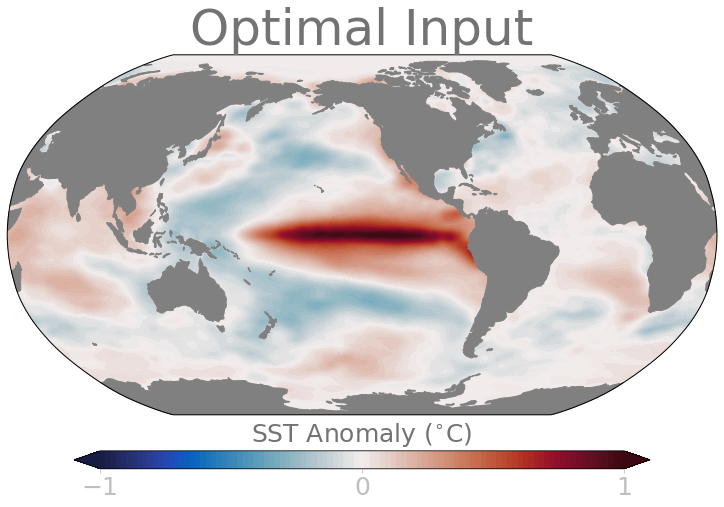

In [24]:
#Change all future font colors here (changing to light gray for dark mode)
rcParams['text.color'] = '0.45'

#Generate the figure instance and axis
fig1 = plt.figure(figsize=(10,5))
ax = plt.axes((0.0,0.0,1.0,1.0),  projection=cartopy.crs.Robinson(central_longitude=225))

#Contour-fill the optimal input
contour_plot = ax.contourf(lons_cyclic, lats, oi_cyclic, levels=np.linspace(-1,1,100), cmap=cmocean.cm.balance, transform=cartopy.crs.PlateCarree(), extend='both')        

#Change some aspects of the figure
ax.set_title('Optimal Input', fontsize=50)
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='face', facecolor='0.5')
ax.set_global()

#Create colorbar
cax = fig1.add_axes([0.1, -0.15, 0.8, 0.05])
cbar = fig1.colorbar(contour_plot, cax=cax, orientation='horizontal', ticks=np.linspace(-1,1,3))
cbar.ax.tick_params(labelsize=25, color='0.75', labelcolor='0.75')
cax.text(x=0.5, y=1.1, s='SST Anomaly ($^{\circ}$C)', rotation=0, ha='center', va='bottom', fontsize=25)



---


---


#Interpretation Step 2: Layerwise Relevance Propagation



Now that we've seen a composite interpretation of what the neural network has learned, we're going to use layerwise relevance propagation (LRP). Using LRP will help us understand what information a neural network uses from each individual sample to makes its predictions.

We first have to slightly modify the neural network before we can use LRP. We remove the softmax layer so that the relevance can be propagated backwards from the pre-softmax output. This is helpful for a few reasons that are discussed at this link: https://github.com/albermax/innvestigate/issues/84

In [0]:
#Remove the softmax layer from the model
model_nosoftmax = innvestigate.utils.model_wo_softmax(model)

#Create the "analyzer", or the object that will generate the LRP heatmaps given an input sample
analyzer = innvestigate.create_analyzer('deep_taylor', model_nosoftmax)

We will now create LRP heatmaps for all of the El Nino (positive ENSO phase) samples. We will only save the LRP heatmaps for the samples that are correctly classified.

In [0]:
#First, create some lists to hold the output
LRP_heatmaps_all = []
accurate_samples_all = []
    
#We will process all of the samples, although another good option is to only process the validation samples
for sample_ind, sample in enumerate(X_all):

      #Do not process any of the La Nina samples; can change this if you would like to see the La Nina samples
      if Y_all[sample_ind,1] == 0:
        continue
    
      #Make a print statement so we know how long it is taking to process the samples
      if (sample_ind%1000 == 0) & (sample_ind > 0):
        print(sample_ind, np.nanmax(dt_all))
      
      #Make the prediction from the model to see if the model correctly identifies the samples as El Nino
      sample_prediction = np.argmax(model.predict(sample[np.newaxis,...]))

      #Continue if the sample is correctly predicted as El Nino...
      if sample_prediction == 1:
        LRP_heatmap = analyzer.analyze(sample[np.newaxis,...])

        LRP_heatmaps_all.append(LRP_heatmap)
        accurate_samples_all.append(sample)

Now that we have collected the LRP heatmaps, we will do some post-processing before making a figure. W


We'll normalize each LRP heatmap by its maximum value so that each heatmap has equal weight when it is composited. We will then make the composite LRP map to compared to optimal input.

In [0]:
#Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
LRP_heatmaps_all = np.array(LRP_heatmaps_all)
LRP_heatmaps_all = LRP_heatmaps_all.reshape(LRP_heatmaps_all.shape[0], len(lats), len(lons))

#Add a cyclic point to the heatmaps for future plotting
LRP_heatmaps_all_cyclic, lons_cyclic = cartopy.util.add_cyclic_point(LRP_heatmaps_all, coord=lons)

#Normalize each heatmap to have a maximum value of 1 so all samples can be compared equally
LRP_heatmaps_all_cyclic = LRP_heatmaps_all_cyclic/np.nanmax(LRP_heatmaps_all_cyclic, axis=(-2,-1))[:,np.newaxis,np.newaxis]

#Now take the mean across all samples to make a composite...
LRP_heatmaps_mean_cyclic = np.nanmean(LRP_heatmaps_all_cyclic, axis=0)

We will now plot a composiet of the LRP heatmaps. This composite is useful for comparing to the optimal input and identifying which regions of the optimal input are likely most important. While the two methods are not directly related, the LRP composite commonly exhibits similar patterns to the optimal input, but helps isolate which regions of the optimal input are particularly important.

Text(0.5, 1.1, 'Relevance (unitless)')

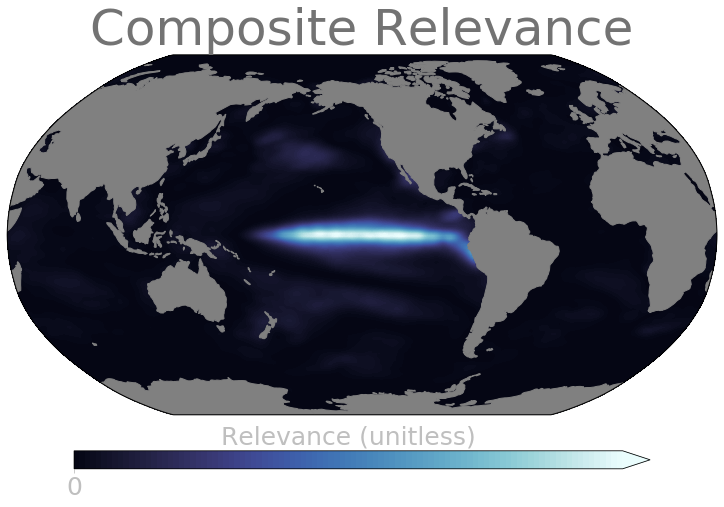

In [29]:
#Generate the figure instance and axis
fig1 = plt.figure(figsize=(10,5))
ax = plt.axes((0.0,0.0,1.0,1.0),  projection=cartopy.crs.Robinson(central_longitude=225))

#Contour-fill the composite relevance
contour_plot = ax.contourf(lons_cyclic, lats, LRP_heatmaps_mean_cyclic, levels=np.linspace(0,0.75,100), transform=cartopy.crs.PlateCarree(),  cmap=cmocean.cm.ice, zorder=0, extend='max')

#Change some aspects of the figure
ax.set_title('Composite Relevance', fontsize=50)
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='face', facecolor='0.5')
ax.set_global()

#Create colorbar
cax = fig1.add_axes([0.1, -0.15, 0.8, 0.05])
cbar = fig1.colorbar(contour_plot, cax=cax, orientation='horizontal', ticks=np.linspace(-1,1,3))
cbar.ax.tick_params(labelsize=25, color='0.75', labelcolor='0.75')
cax.text(x=0.5, y=1.1, s='Relevance (unitless)', rotation=0, ha='center', va='bottom', fontsize=25, color='0.75')

We will now plot the optimal input, LRP composite, and observed composite El Nino sea-surface temperature pattern.

First, we need to generate a composite of the El Nino samples.

In [0]:
#We first need to create the composite of all El Nino samples
elnino_composite = np.mean( sst[Y_all[:,1] == 1], axis=0).reshape(len(lats),len(lons)) #Gather only the El Nino samples, and take the mean

#Re-scale the El Nino composite to have a maximum value of 1, as we did with our optimal input field
elnino_composite = elnino_composite / np.nanmax(np.abs(elnino_composite))

#Add a cyclic point so we can plot on a map
elnino_composite_cyclic, lons_cyclic = cartopy.util.add_cyclic_point(elnino_composite, coord=lons)

...and now we can make the figure comparing optimal input, LRP, and the observed El Nino composite. This figure is large, so you will have to scroll to see it all.



Text(0.5, 1.1, 'Observed SST Anomaly ($^{\\circ}$C)')

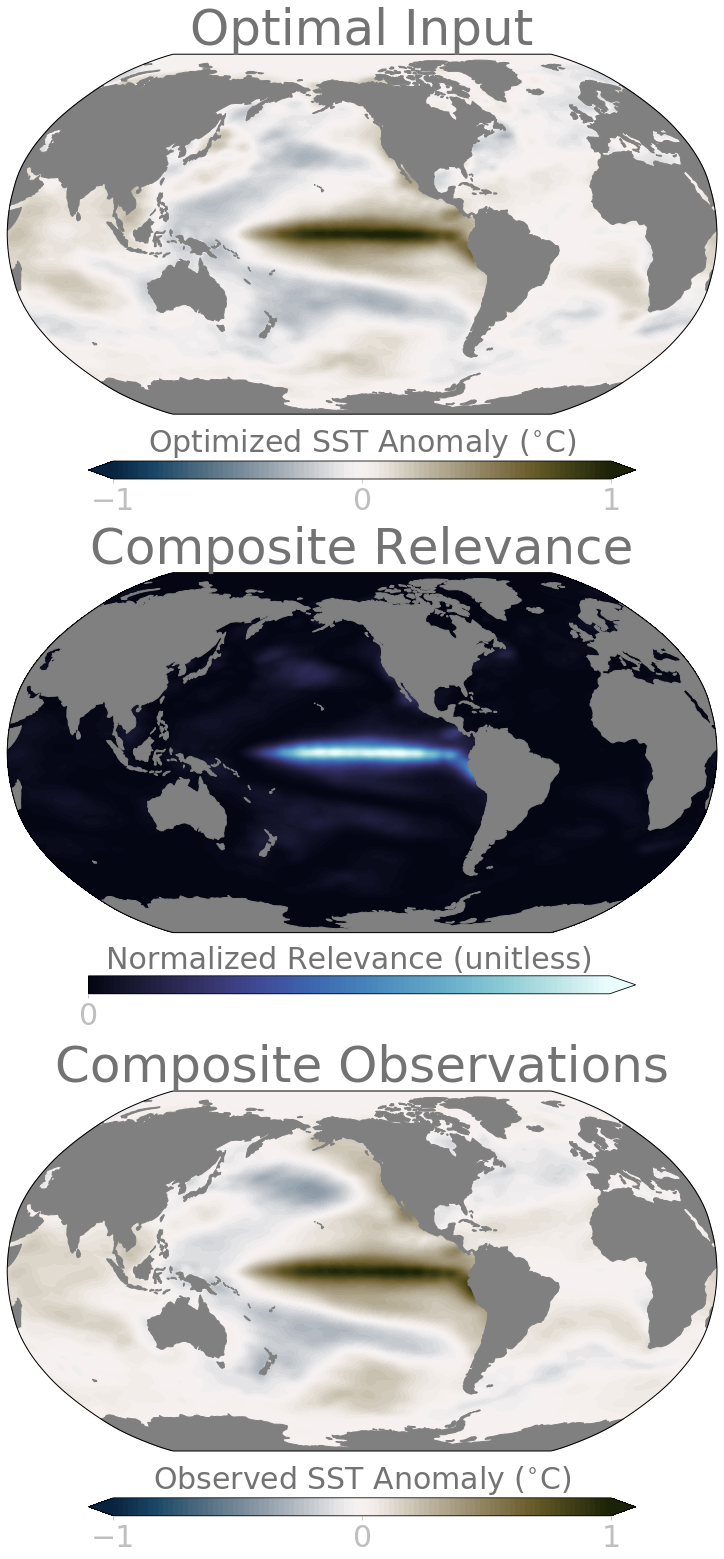

In [31]:
#Axes instance for the optimal input 
fig1 = plt.figure(figsize=(20,10))

ax = plt.axes((0.0,0.5,0.5,0.5),  projection=cartopy.crs.Robinson(central_longitude=225))

#Contour-fill the optimal input
contour_plot_1 = ax.contourf(lons_cyclic, lats, oi_cyclic, levels=np.linspace(-1,1,100), cmap=cmocean.cm.diff, transform=cartopy.crs.PlateCarree(), extend='both')        

#Change some aspects of the figure
ax.set_title('Optimal Input', fontsize=50)
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='face', facecolor='0.5')
ax.set_global()

#Create colorbar
cax = fig1.add_axes([0.06, 0.41, 0.38, 0.025])
cbar = fig1.colorbar(contour_plot_1, cax=cax, orientation='horizontal', ticks=np.linspace(-1,1,3))
cbar.ax.tick_params(labelsize=30, color='0.75', labelcolor='0.75')
cax.text(x=0.5, y=1.1, s='Optimized SST Anomaly ($^{\circ}$C)', rotation=0, ha='center', va='bottom', fontsize=30)


#Axes instance for the composite LRP heatmap
ax = plt.axes((0.0,-0.22,0.5,0.5),  projection=cartopy.crs.Robinson(central_longitude=225))

#Contour-fill the composite relevance
contour_plot_2 = ax.contourf(lons_cyclic, lats, LRP_heatmaps_mean_cyclic, levels=np.linspace(0,0.75,100), transform=cartopy.crs.PlateCarree(),  cmap=cmocean.cm.ice, zorder=0, extend='max')

#Change some aspects of the figure
ax.set_title('Composite Relevance', fontsize=50)
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='face', facecolor='0.5')
ax.set_global()

#Create colorbar
cax = fig1.add_axes([0.06, 0.41 - 0.57 - 0.145, 0.38, 0.025])
cbar = fig1.colorbar(contour_plot_2, cax=cax, orientation='horizontal', ticks=[0])
cbar.ax.tick_params(labelsize=30, color='0.75', labelcolor='0.75')
cax.text(x=0.5, y=1.1, s='Normalized Relevance (unitless)', rotation=0, ha='center', va='bottom', fontsize=30)


#Axes instance for the observed El Nino pattern
ax = plt.axes((0.0,-0.94,0.5,0.5),  projection=cartopy.crs.Robinson(central_longitude=225))

#Contour-fill the composite El Nino observations
contour_plot_3 = ax.contourf(lons_cyclic, lats, elnino_composite_cyclic, levels=np.linspace(-1,1,100), cmap=cmocean.cm.diff, transform=cartopy.crs.PlateCarree(), extend='both')        

#Change some aspects of the figure
ax.set_title('Composite Observations', fontsize=50)
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='face', facecolor='0.5')
ax.set_global()

#Create colorbar
cax = fig1.add_axes([0.06, 0.41 - 0.57*2 - 0.145*2 - 0.01, 0.38, 0.025])
cbar = fig1.colorbar(contour_plot_3, cax=cax, orientation='horizontal', ticks=np.linspace(-1,1,3))
cbar.ax.tick_params(labelsize=30, color='0.75', labelcolor='0.75')
cax.text(x=0.5, y=1.1, s='Observed SST Anomaly ($^{\circ}$C)', rotation=0, ha='center', va='bottom', fontsize=30)

Great! It looks like the optimal input and LRP agree well. LRP tells us that, at least in a composite sense, the neural network looks at the tropical Pacific to identify El Nino events. This is reassuring, since we know that El Nino is best characterized by warm surface temperature anomalies within the central and eastern Pacific.

We can make things even more interesting by looking at the LRP heatmaps for each individual sample. We will do this in the below code. We'll use some of the arrays we created back when we first ran LRP over all of our samples.

In [0]:
#First, remap our samples back into maps (we vectorized them for training)
accurate_samples_all = np.array(accurate_samples_all)
accurate_samples_all = accurate_samples_all.reshape(accurate_samples_all.shape[0],len(lats),len(lons))

#Add a cyclic point for plotting
accurate_samples_all_cyclic, lons_cyclic = cartopy.util.add_cyclic_point(accurate_samples_all, coord=lons)

And now we can make the plots! We will plot the sea-surface temperatures in fill and overlay the LRP heatmaps as open contours. This will tell us which regions of sea-surface temperature anomalies the neural network used to correctly classify each individual sample.


You can change the sample that is plotted by changing the "index_to_plot" variable to another index. 

Lighter open contours represent higher relevance values.

Text(1.65, 0.05, 'Higher Relevance')

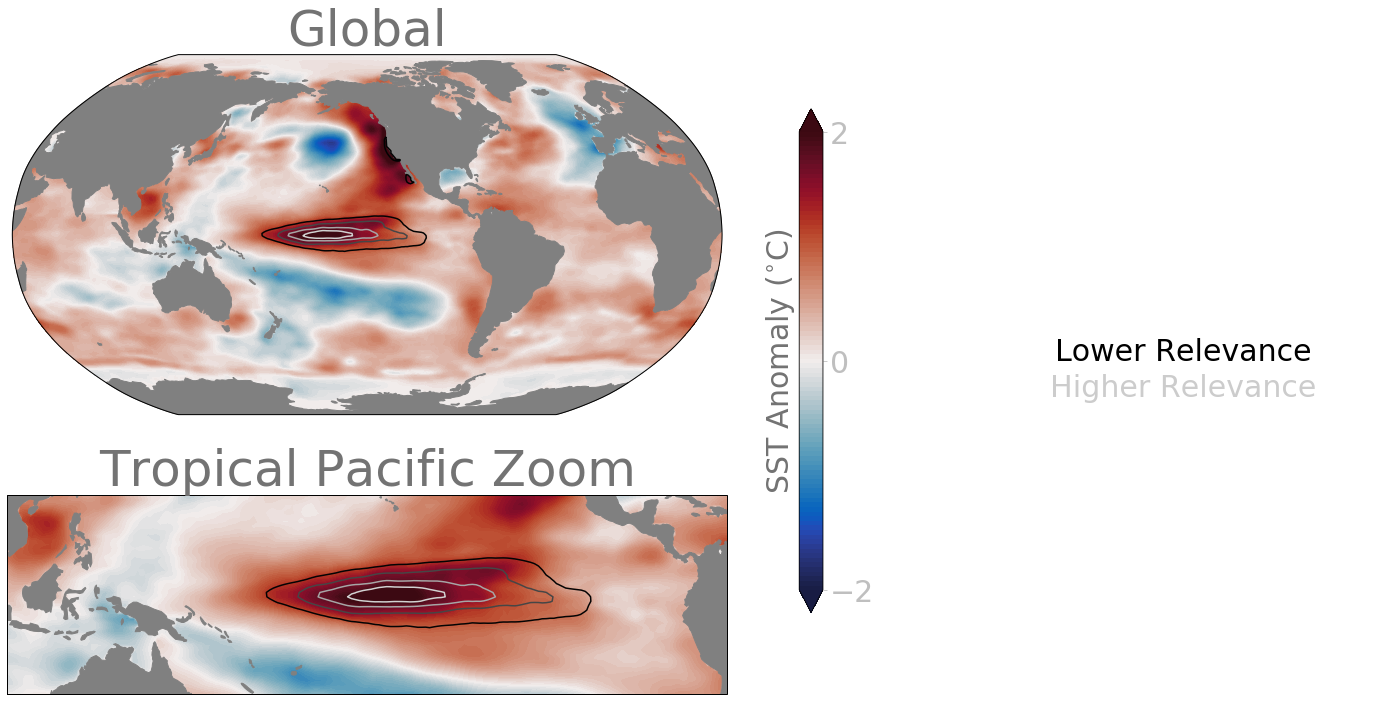

In [33]:
#NOTE: You can change the index that you would like to plot using the below variables.
#   Changes these indices will change the sample that you plot, so you can get a good feeling for the variability of the LRP heatmaps across samples
index_to_plot = 1

#Create a list of colors for the LRP relevance
colors = ['0.01','0.275','0.65','0.825','1']

fig1 = plt.figure(figsize=(20,10))

#Axes instance for the global plot of SST with the relevance overlain in open contours
ax1 = plt.axes((0.0,0.5,0.5,0.5),  projection=cartopy.crs.Robinson(central_longitude=225))

#Contour-fill the SST and open contour the relevance
contour_plot_1 = ax1.contourf(lons_cyclic, lats, accurate_samples_all_cyclic[index_to_plot], levels=np.linspace(-2,2,100), cmap=cmocean.cm.balance, transform=cartopy.crs.PlateCarree(), extend='both')        
contour_plot_2 = ax1.contour(lons_cyclic, lats, LRP_heatmaps_all_cyclic[index_to_plot], levels=np.linspace(0.2,1.0,5), transform=cartopy.crs.PlateCarree(),  colors=colors, zorder=2)

#Change some aspects of the figure
ax1.set_title('Global', fontsize=50)
ax1.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='face', facecolor='0.5')
ax1.set_global()

#Axes instance for the zooms on the tropical pacific
ax2 = plt.axes((0.0,0.0,0.5,0.5),  projection=cartopy.crs.Robinson(central_longitude=225))

#Contour-fill the SST and open contour the relevance
contour_plot_3 = ax2.contourf(lons_cyclic, lats, accurate_samples_all_cyclic[index_to_plot], levels=np.linspace(-2,2,100), cmap=cmocean.cm.balance, transform=cartopy.crs.PlateCarree(), extend='both')        
contour_plot_4 = ax2.contour(lons_cyclic, lats, LRP_heatmaps_all_cyclic[index_to_plot], levels=np.linspace(0.2,1.0,5), transform=cartopy.crs.PlateCarree(),  colors=colors, zorder=2)

#Change some aspects of the figure
ax2.set_title('Tropical Pacific Zoom', fontsize=50)
ax2.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='face', facecolor='0.5')
ax2.set_extent([105, 290, -22.5, 22.5], crs=cartopy.crs.PlateCarree())

#Create colorbar
cax = fig1.add_axes([0.55, 0.225, 0.0165, 0.7])
cbar = fig1.colorbar(contour_plot_3, cax=cax, orientation='vertical', ticks=np.linspace(-2,2,3))
cbar.ax.tick_params(labelsize=30, color='0.75', labelcolor='0.75')
cax.text(x=-0.1, y=0.5, s='SST Anomaly ($^{\circ}$C)', rotation=90, ha='right', va='center', fontsize=30)

#Create contour color legend
plt.text(1.65,0.275,'Relevance Contour Legend', transform=ax1.transAxes, ha='center', fontsize=30, color='1')
plt.text(1.65,0.15,'Lower Relevance', transform=ax1.transAxes, ha='center', fontsize=30, color='0')
plt.text(1.65,0.05,'Higher Relevance', transform=ax1.transAxes, ha='center', fontsize=30, color='0.8')


#Congratulations! 

You are now well on your way to being an expert in neural network interpretability.

We have covered two of the most powerful interpretation methods. Using these two methods and your newfound confidence in interpreting neural networks, you can delve deeper and discover how these and other methods can uncover connections within your own geoscientific data.

I hope you enjoyed this session!

-Ben

#References for Additional Reading

##Optimal Input
**Within Geoscience**: Interpretable Neural Networks for Geoscience: Toms, Benjamin A., Elizabeth A. Barnes, and Imme Ebert-Uphoff. “Physically interpretable neural networks for the geosciences: Applications to earth system variability”, https://arxiv.org/abs/1912.01752.

**Within Geoscience**: McGovern, A., Lagerquist, R., Gagne, D. J., Jergensen, G. E., Elmore, K. L., Home-yer, C. R., & Smith, T.(2019).Making the black box more transparent:Understanding the physical implications of machine learning.Bulletin of theAmerican Meteorological Society.

**Within Geoscience**: Gagne, D. J., Haupt, S. E., Nychka, D. W., & Thompson, G.   (2019).   Interpretabledeep learning for spatial analysis of severe hailstorms.Monthly Weather Re-view,147(8), 2827–2845.

**Computer Science Paper**: Olah, C., Mordvintsev, A., & Schubert, L.    (2017).    Feature visualization. Distill, 2(11).

**Computer Science Paper**: Simonyan, K., Vedaldi, A., & Zisserman, A.(2013).Deep inside convolutionalnetworks:  Visualising image classification models and saliency maps.arXivpreprint arXiv:1312.6034.

**Computer Science Paper**: Yosinski, J., Clune, J., Nguyen, A., Fuchs, T., & Lipson, H.   (2015).   Understandingneural networks through deep visualization.arXiv preprint arXiv:1506.06579.



##Layerwise Relevance Propagation
**Within Geoscience**: Interpretable Neural Networks for Geoscience: Toms, Benjamin A., Elizabeth A. Barnes, and Imme Ebert-Uphoff. “: Applications to earth system variability”, https://arxiv.org/abs/1912.01752.

**Fundamental Theory**: Bach, S., Binder, A., Montavon, G., Klauschen, F., M ̈uller, K.-R., & Samek, W.(2015).On pixel-wise explanations for non-linear classifier decisions by layer-wise relevance propagation.PloS one,10(7), e0130140.

**Fundamental Theory**: Montavon, G., Lapuschkin, S., Binder, A., Samek, W., & M ̈uller, K.-R.   (2017).   Ex-plaining nonlinear classification decisions with deep taylor decomposition.Pat-tern Recognition,65, 211–222.


##General Interpretability
**Intro to Feature Visualization**:    Olah, C., et al. “Feature Visualization.” Distill, 2017, https://distill.pub/2017/feature-visualization/.

**Book on Explainable AI**: W Samek, G Montavon, A Vedaldi, LK Hansen, KR Müller (Eds.) Explainable AI: Interpreting, Explaining and Visualizing Deep Learning, Springer LNCS 11700, 2019

